<div class="alert alert-info">

<H1> Data Analysis Interview Challenge </H1>

<H2> Part 1 ‑ Exploratory data analysis </H2>


<h3> Objectives </h3>
Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them. 

<p>
<H5> This log data contains (simulated) timestamps of user logins to a platform in a particular
geographic location. </H5>
</p>
</div>


In [4]:
conda install -c anaconda py-xgboost

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
# imports
import pandas as pd
import numpy as np
import json
import pickle


# data viz imports
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns


# time-series imports
from datetime import datetime


# imports for xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

<div class="alert alert-success">
<H3> Clean and Wrangle Data </H3>
</div>

In [6]:
# load data as a data frame
login_data = pd.read_json('data/logins.json')

# examine first five records
login_data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [7]:
# add a column to represent the number of logins during each time
login_data['login_count'] = 1

# convert the date to a datetime object, and set it as the index
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))[['login_count']]

# examine first five records
login_data.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


<div class="alert alert-success">
<H3> Process time-series data into 15min chunks </H3>
</div>

In [9]:
# resample the index, so that time is represented in 15min chunks
logins_delta15 = login_data.resample('15Min').sum()

# examine first 5 records
logins_delta15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


<div class="alert alert-success">
<H3> Visualize processed data </H3>
</div>

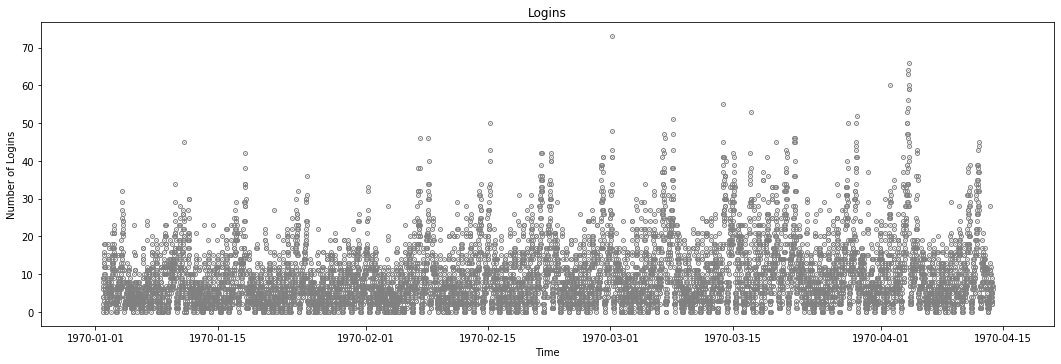

In [21]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')

# puts the data in the figure
plt.scatter(logins_delta15.index, logins_delta15.login_count, s=1, facecolor='0.5', lw = 4)

<div class="alert alert-warning">
<strong>The underlining data shows a consistent pattern from a high level however it is difficult to discern any true trends. More analysis will certainly be needed.
    </strong>
</div>
    

<div class="alert alert-success">
<H3> Better understand time-series data </H3>
    <ol>
        <li>Look at the entire time-series with a larger chunksize</li>
        <li>Look at specific days separately</li>
        <li>Find the busiest time of day</li>
    </ol>
</div>

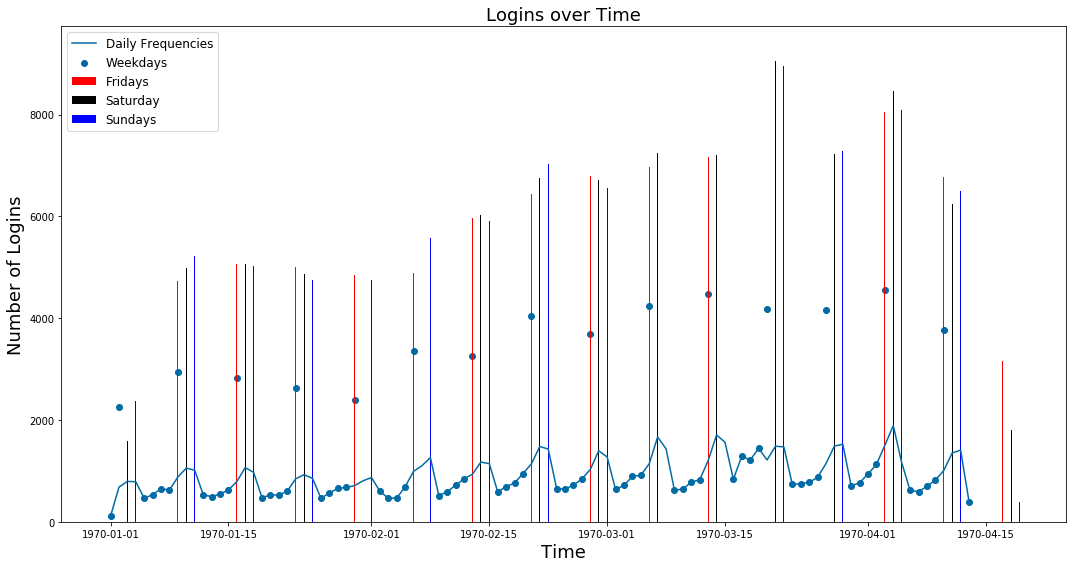

In [29]:
# bin data by various day type groupings
logins_daily = login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Number of Logins', fontsize = 18)
plt.title('Logins over Time', fontsize = 18)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'r')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'b')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 12)
plt.tight_layout()

<div class="alert alert-warning">
<strong>The above graph makes it clear that Friday, and even Sunday has the most logins, and that the weekends are busier than the weekdays by a long stretch.</strong>
</div>

<div class="alert alert-success">
<H3> Find hourly trends by day of week</H3>
</div>

In [30]:
# resample index hourly
daily_logins = login_data.resample('H').sum()

# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week

# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

# examine first 5 records
daily_logins.head()

,login_count,day_of_week,hour
login_time,,,
1970-01-01 20:00:00,24,3,20
1970-01-01 21:00:00,9,3,21
1970-01-01 22:00:00,21,3,22
1970-01-01 23:00:00,58,3,23
1970-01-02 00:00:00,53,4,0


In [35]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', 
                                   index = 'hour', 
                                   columns = 'day_of_week', 
                                   aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])

# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()[['day_of_week', 'hour', 'avg_num_logins']]

# examine first 5 records
avg_hourly_logins_df.head()

,day_of_week,hour,avg_num_logins
0,Monday,0,35.400000
1,Tuesday,0,43.357143
2,Wednesday,0,49.071429
3,Thursday,0,58.285714
4,Friday,0,65.000000


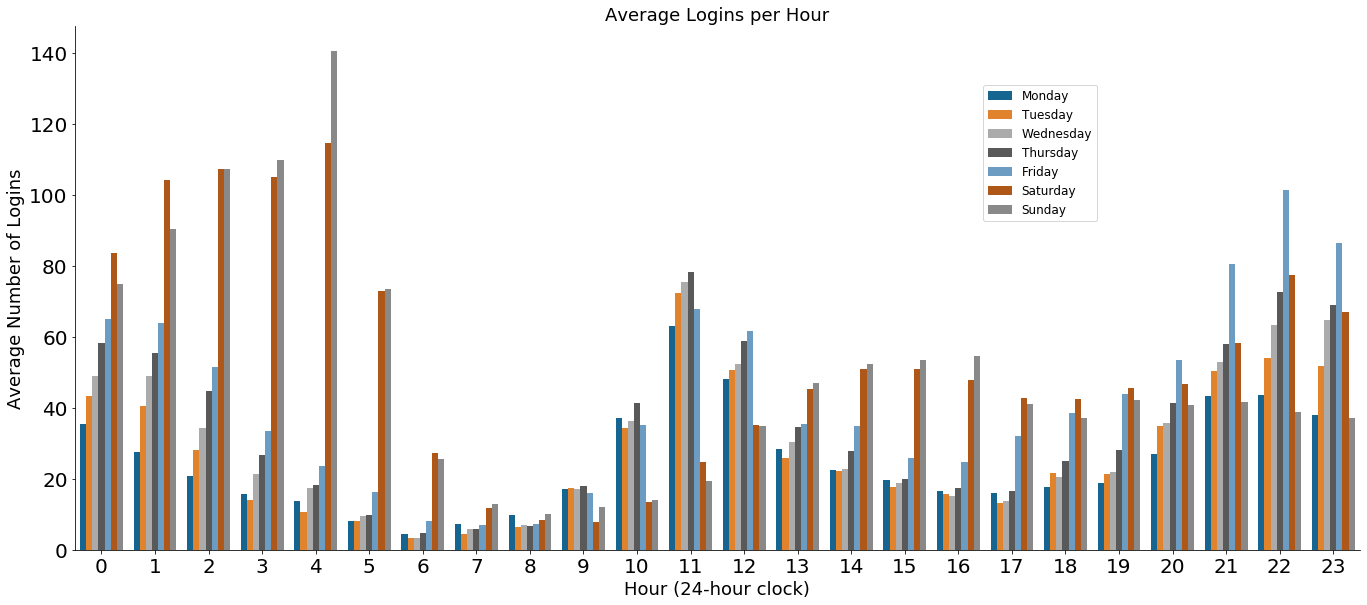

In [37]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', 
                data=avg_hourly_logins_df, 
                kind = 'bar', 
                hue='day_of_week',
                height=8, aspect=11.7/5, 
                legend=False)

ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 18)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 18)
ax.set_ylabel('Average Number of Logins', fontsize = 18)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=12)

<div class="alert alert-warning">
<strong>The bar graph shows the heaviest usage occurs during the early hours (1 AM - 5 AM) on Saturday and Sunday.  During the weekdays there are smaller spikes in usage during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM).</strong>
</div>